In [3]:
import os
import pandas as pd

data_dir = "./data"

# list of dataframes from each month of the year
monthly_dfs = []

for folder_name in os.listdir(data_dir):
    folder = data_dir + "/" + folder_name
    
    # dfs for each day of the month
    days_dfs = []
    for file in os.listdir(folder):
        file_path = folder + "/" + file
        days_dfs.append(pd.read_csv(file_path, header=0, index_col=0, parse_dates=True, squeeze=True))
        
    # df for the entire month
    month_df = pd.concat(days_dfs, axis=0)
    monthly_dfs.append(month_df)
    
# dataframe for full year worth of data
year_df = pd.concat(monthly_dfs, axis=0)

print(year_df)
        
        


                       Name   PTID  LBMP ($/MWHr)  \
Time Stamp                                          
2019-03-02 00:05:00  CAPITL  61757          33.95   
2019-03-02 00:05:00  CENTRL  61754          31.99   
2019-03-02 00:05:00  DUNWOD  61760          33.88   
2019-03-02 00:05:00  GENESE  61753          31.17   
2019-03-02 00:05:00     H Q  61844          30.63   
...                     ...    ...            ...   
2019-06-26 00:00:00   NORTH  61755         -13.20   
2019-06-26 00:00:00     NPX  61845          19.80   
2019-06-26 00:00:00     O H  61846          17.25   
2019-06-26 00:00:00     PJM  61847          19.32   
2019-06-26 00:00:00    WEST  61752          17.54   

                     Marginal Cost Losses ($/MWHr)  \
Time Stamp                                           
2019-03-02 00:05:00                           2.37   
2019-03-02 00:05:00                           0.41   
2019-03-02 00:05:00                           2.30   
2019-03-02 00:05:00                     

# Historical Price Analysis

In this section we will analyze the historic Location Based Marginal Pricing (LBMP) data we retrieved. We will look at the LBMP at three different locations over the course of the year 2019. We define model parameters, derived quantities and assumptions as follows:

Notation for model parameters:

  * $p$ : price per unit of carbon offsets (\$ / ton $CO_2$), constant 
  * $c_t$ : cost of electric power in hour $t$ (\$ / MWh): changes each hour (LBMP)
  * $\lambda$ : power consumed per carbon offset produced (MWh / ton $CO_2$), constant
    - Hence $1/\lambda$ measures plant efficiency
  * $N$ : plant maximum capture rate (ton $CO_2$/h), constant
  * $t = 1, \ldots, T$ : index of hours in the calendar year ($T \approx 8260$ )

Derived quantities:

  * $C_t = c_t \lambda N$ : total costs of power, if plant is operating at maximum capacity
  * $R_t = \max\{p-c_t \lambda, 0\}N$ : operating revenue in hour $t$, assuming optimal operations 

Definitions:

  * *Operating net income*: total revenues from carbon offsets less cost of power
  
Assumptions for short-run decision:

  * If operating net income is positive, plant will operate at maximum capacity.
  
Hence $R_t = max\{(p-c_t\lambda)N, 0\}$.

Let $\bar{c} = p/\lambda$. 

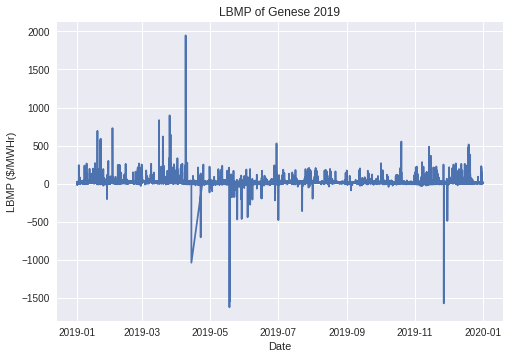

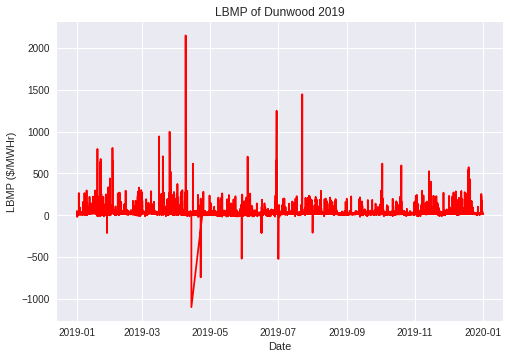

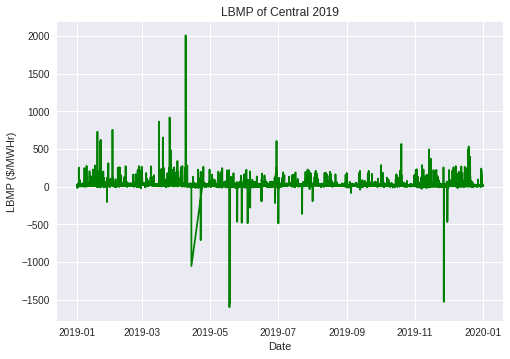

In [10]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

# Get data for three locations
genese = year_df[year_df["Name"] == "GENESE"]
dunwood = year_df[year_df["Name"] == "DUNWOD"]
central = year_df[year_df["Name"] == "CENTRL"]

#plot genese central and dunwood
plt.xlabel('Date') 
plt.ylabel('LBMP ($/MWHr)') 

plt.title("LBMP of Genese 2019") 
plt.plot(genese.index, genese["LBMP ($/MWHr)"])
plt.savefig('./figures/figure1.png')
plt.show()


plt.xlabel('Date') 
plt.ylabel('LBMP ($/MWHr)') 

plt.title("LBMP of Dunwood 2019") 
plt.plot(dunwood.index, dunwood["LBMP ($/MWHr)"], color='red')
plt.savefig('./figures/figure2.png')
plt.show()


plt.xlabel('Date') 
plt.ylabel('LBMP ($/MWHr)') 

plt.title("LBMP of Central 2019") 
plt.plot(central.index, central["LBMP ($/MWHr)"], color='green')
plt.savefig('./figures/figure3.png')
plt.show()



Now that we can visualize our data for Genese, Dunwood, and Central we can see that the LBMP is volatile throughout the year and has no clear pattern or relationship. There are sporadic positive and negative spikes in the data which may be explained through further research. For the purpose of this investigation this is helpful as it better helps us understand the data. Next, we plot the frequency histograms of LBMP for the three locations.

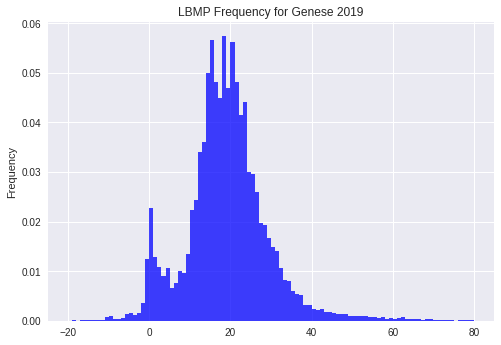

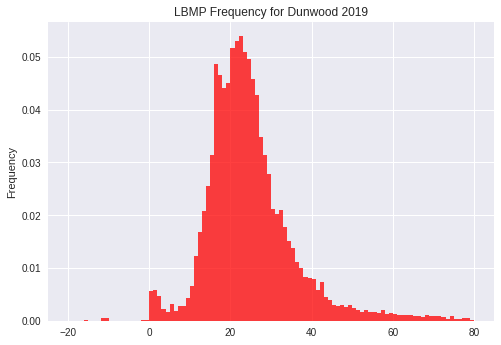

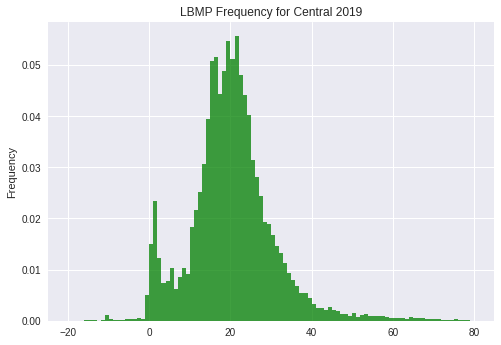

In [9]:
plt.title("LBMP Frequency for Genese 2019") 
plt.ylabel('Frequency') 
plt.hist(genese["LBMP ($/MWHr)"], 100, range=[-20, 80], density=True, histtype='bar', color='blue', alpha=0.75)
plt.savefig('./figures/figure4.png')
plt.show()


plt.title("LBMP Frequency for Dunwood 2019") 
plt.ylabel('Frequency') 
plt.hist(dunwood["LBMP ($/MWHr)"], 100, range=[-20,80], density=True, histtype='bar', color='red', alpha=0.75)
plt.savefig('./figures/figure5.png')
plt.show()


plt.title("LBMP Frequency for Central 2019") 
plt.ylabel('Frequency') 
plt.hist(central["LBMP ($/MWHr)"], 100, range=[-20,80], density=True, histtype='bar', color='green', alpha=0.75)
plt.savefig('./figures/figure6.png')
plt.show()


Now that we can better understand our data, we will perform our feasability analysis of DAC profit potiential given model parameters. The parameter 'co_offset' is the price of carbon offsets per ton of CO2 captured and removed from the atmosphere. The parameter 'lmbda' is our lambda that corresponds to the power consumed per carbon offset produced (MWh/ton CO2). The parameter 'capacity' is the capacity of a plant in tons of CO2/hr. Finally, 'yr_op_expenses' represents the yearly operating expenses of a plant including the cost of employees, debts, and other fixed costs.

In [28]:
# Enter model parameters

co_offset = 100   # price in $ of carbon offsets per ton ($/Ton CO2)

lmbda = 2.5        # power consumed per carbon offset produced, MWh/ton CO2

capacity = 1       # plant capacity, tons CO2/hr

yr_op_expenses = 250000    # Yearly operating expenses

Since our data tracks the LBMP every five minutes we first calculate the revenue per hour of a given LBMP and convert that into the revenur for that 5 minute period instead. We assume that in order to optimize profits, the DAC will run only when the LBMP will allow for a break even or profit. Hence, after calculating revenues for every 5 minute increment of the year, we remove all negative values to simulate the DAC shutting off during those times. 

Genese Revenues Preview:
                      Revenue ($)
Time Stamp                      
2019-03-02 00:05:00     0.735833
2019-03-02 00:10:00     0.745000
2019-03-02 00:15:00     0.735833
2019-03-02 00:20:00     0.735833
2019-03-02 00:25:00     0.741667




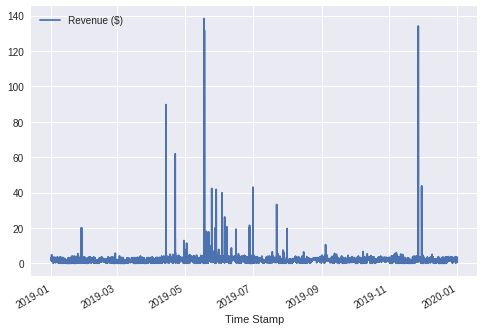

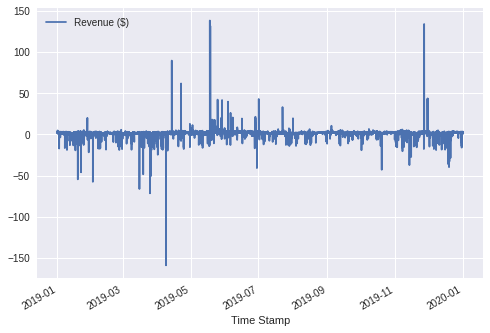

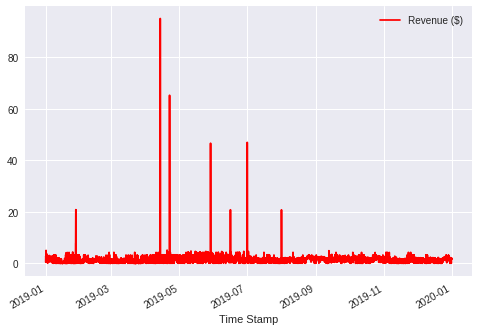

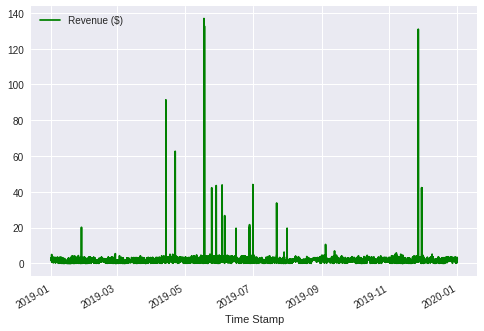

In [29]:

# This will give us the revenue given data from one observation
def RevenuePer5Mins(lbmp):
    rev_hr = (co_offset - (lbmp*lmbda))*capacity
    return (rev_hr/60.0) *5

# create empty lists
genese_revs, dunwood_revs, central_revs = [], [], []

# Calculate revenue per 5 minutes for the three locations
for lbmp in genese["LBMP ($/MWHr)"]:
    genese_revs.append(RevenuePer5Mins(lbmp))
    
for lbmp in dunwood["LBMP ($/MWHr)"]:
    dunwood_revs.append(RevenuePer5Mins(lbmp))
    
for lbmp in central["LBMP ($/MWHr)"]:
    central_revs.append(RevenuePer5Mins(lbmp))

# Make dataframes of revenues for different locations with time stamps. 
genese_revs_df = pd.DataFrame(genese_revs, index=genese.index, columns =['Revenue ($)'])
dunwood_revs_df = pd.DataFrame(dunwood_revs, index=dunwood.index, columns =['Revenue ($)'])
central_revs_df = pd.DataFrame(central_revs, index=central.index, columns =['Revenue ($)'])

# Save original dataframes 
genese_revs_og = genese_revs_df
dunwood_revs_og = dunwood_revs_df
central_revs_og = central_revs_df


print("Genese Revenues Preview:\n", genese_revs_df.head())
print("\n")

# Assuming we only run the DAC when the LBMP will create a break even or profit we will remove all negative values
genese_revs_df = genese_revs_df[genese_revs_df['Revenue ($)'] > 0]
dunwood_revs_df = dunwood_revs_df[dunwood_revs_df['Revenue ($)'] > 0]
central_revs_df = central_revs_df[central_revs_df['Revenue ($)'] > 0]

genese_revs_df.plot()
plt.savefig('./figures/figure7.png')

genese_revs_og.plot()
plt.savefig('./figures/figure7u.png')

dunwood_revs_df.plot(color="red")
plt.savefig('./figures/figure8.png')

central_revs_df.plot(color="green")
plt.savefig('./figures/figure9.png')

Now that we have calculated our revenues, we can easily determine our annual operating revenues by taking the sum of all revenues for 5 minute increments throughout the year. We then factor in our yearly expenses and subtract that from our revenues to get our true net revenues. With this analysis, we will be able to determine whether a DAC facility is profitable for an investor or stakeholder. Furthermore, it can aid decision makers in deciding which locations are optimal for DAC investment.

In [30]:
# Yearly Net Operating Revenue
genese_op_rev = genese_revs_df.sum()
dunwood_op_rev = dunwood_revs_df.sum()
central_op_rev = central_revs_df.sum()

#Yearly Net Operating revenue unoptimized
og_genese_rev = genese_revs_og.sum()
og_dunwood_rev = dunwood_revs_og.sum()
og_central_rev = central_revs_og.sum()

print("Genese Yearly Operating", genese_op_rev)
print("Genese Unoptimized Yearly Operating", og_genese_rev)
print("\n")

print("Dunwood Yearly Operating", dunwood_op_rev)
print("Dunwood Unoptimized Yearly Operating", og_dunwood_rev)
print("\n")

print("Central Yearly Operating", central_op_rev)
print("Central Unoptimized Yearly Operating", og_central_rev)
print("\n")

genese_net_rev = genese_op_rev - yr_op_expenses
dunwood_net_rev = dunwood_op_rev - yr_op_expenses
central_net_rev = central_op_rev - yr_op_expenses

# Unoptimized net revs
u_genese_net_rev = og_genese_rev - yr_op_expenses
u_dunwood_net_rev = og_dunwood_rev - yr_op_expenses
u_central_net_rev = og_central_rev - yr_op_expenses

print("Genese Net ", genese_net_rev)
print("Unoptimized Genese Net ", u_genese_net_rev)
print("\n")

print("Dunwood Net", dunwood_net_rev)
print("Unoptimized Dunwood Net", u_dunwood_net_rev)
print("\n")

print("Central Net", central_net_rev)
print("Unoptimized Central Net", u_central_net_rev)



Genese Yearly Operating Revenue ($)    189343.734167
dtype: float64
Genese Unoptimized Yearly Operating Revenue ($)    178223.014167
dtype: float64


Dunwood Yearly Operating Revenue ($)    141234.774167
dtype: float64
Dunwood Unoptimized Yearly Operating Revenue ($)    116030.996667
dtype: float64


Central Yearly Operating Revenue ($)    178335.2875
dtype: float64
Central Unoptimized Yearly Operating Revenue ($)    166000.73
dtype: float64


Genese Net  Revenue ($)   -60656.265833
dtype: float64
Unoptimized Genese Net  Revenue ($)   -71776.985833
dtype: float64


Dunwood Net Revenue ($)   -108765.225833
dtype: float64
Unoptimized Dunwood Net Revenue ($)   -133969.003333
dtype: float64


Central Net Revenue ($)   -71664.7125
dtype: float64
Unoptimized Central Net Revenue ($)   -83999.27
dtype: float64


# Conclusion

In summary, we have developed a sound analytical model to determine the profit potiential of DAC facilities based on market data of LBMP prices over the course of a year. This is valuable because as Virginia works to achieve a cleaner environment, environment saving devices such as DAC devices must be financially sustainable and/or profitable in order to be implemented. This analysis, can determine both the potiential annual revenue of a DAC device as well as which regions will provide the most profitable for DAC installation. Furthermore, this analysis is the basis for further development of an analytical tool that will aid decision makers in their investment decisions for DAC facilities.